# Part III: Build Transformer with PyTorch [25 points]
Implement a Transformer model from scratch using the PyTorch framework. Train the model on a provided dataset, exploring various optimization techniques and hyperparameter tuning to achieve optimal performance.
Every component of the Transformer as defined in the paper is expected to be implemented.
The final model should achieve a test accuracy of greater than 80%.

In [1]:
!pip install torchinfo

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from collections import Counter
import torch
import math
import torch.nn as nn
from torchinfo import summary
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from itertools import product
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.nn.utils.rnn import pad_sequence
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

## Step 1: Data Exploration and Preprocessing

1. Select one dataset from the list above.

In [3]:
train_data = pd.read_csv('/content/train.csv', header=None, names=['Class', 'Title', 'Description'])
test_data = pd.read_csv('/content/test.csv', header=None, names=['Class', 'Title', 'Description'])
print("Sample Training Data:")
print(train_data.head())
print("\nSample Testing Data:")
print(test_data.head())

Sample Training Data:
   Class                                              Title  \
0      3  Wall St. Bears Claw Back Into the Black (Reuters)   
1      3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3      3  Iraq Halts Oil Exports from Main Southern Pipe...   
4      3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  

Sample Testing Data:
   Class                                              Title  \
0      3                  Fears for T N pension after talks   
1      4  The Race is On: Second Private Team Sets Launc...   
2      4      Ky. Company Wins Grant to Study Peptides (AP

2. Data exploration:
   - Read, preprocess, and print the main statistics about the dataset.
   - Use libraries like matplotlib, seaborn, or plotly to create at least 3 informative visualizations that reveal insights about the data and potential anomalies (e.g., polarity distribution, word count distribution, vocabulary size etc).

In [4]:
merged_df = pd.concat([train_data, test_data], ignore_index=True)
merged_df['FullText'] = merged_df['Title'] + ' ' + merged_df['Description']
merged_df['Class'] = merged_df['Class'] - 1
merged_df = merged_df[['Class', 'FullText']]
print(merged_df.head())
print(merged_df.info())
print(merged_df.describe())

   Class                                           FullText
0      2  Wall St. Bears Claw Back Into the Black (Reute...
1      2  Carlyle Looks Toward Commercial Aerospace (Reu...
2      2  Oil and Economy Cloud Stocks' Outlook (Reuters...
3      2  Iraq Halts Oil Exports from Main Southern Pipe...
4      2  Oil prices soar to all-time record, posing new...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127600 entries, 0 to 127599
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Class     127600 non-null  int64 
 1   FullText  127600 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.9+ MB
None
               Class
count  127600.000000
mean        1.500000
std         1.118038
min         0.000000
25%         0.750000
50%         1.500000
75%         2.250000
max         3.000000


In [5]:
print("Dataset Statistics:")
print("Normalized Class Distribution:")
print(merged_df['Class'].value_counts(normalize=True))
merged_df['WordCount'] = merged_df['FullText'].apply(lambda x: len(str(x).split()))
print("Average Word Count:", merged_df['WordCount'].mean())
print("Minimum Word Count:", merged_df['WordCount'].min())
print("Maximum Word Count:", merged_df['WordCount'].max())
print("Word Count Standard Deviation:", merged_df['WordCount'].std())

Dataset Statistics:
Normalized Class Distribution:
Class
2    0.25
3    0.25
1    0.25
0    0.25
Name: proportion, dtype: float64
Average Word Count: 37.84
Minimum Word Count: 8
Maximum Word Count: 177
Word Count Standard Deviation: 10.087911853500835


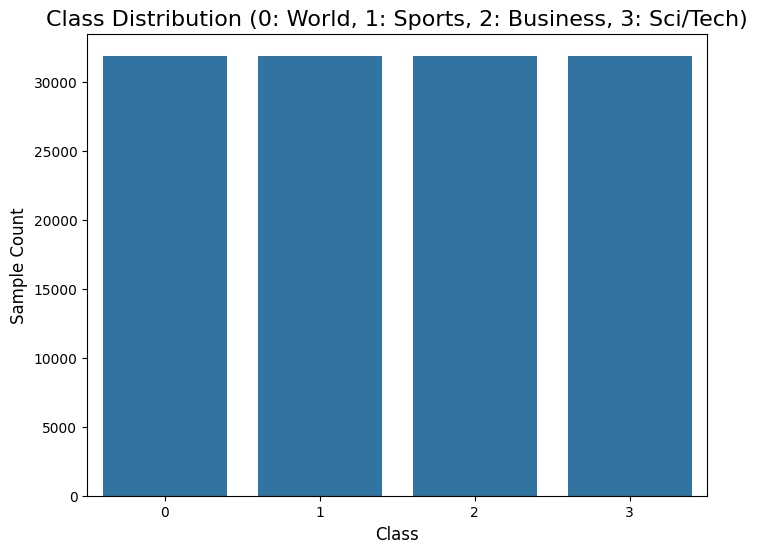

In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=merged_df)
plt.title('Class Distribution (0: World, 1: Sports, 2: Business, 3: Sci/Tech)', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Sample Count', fontsize=12)
plt.show()

The Class Distribution bar plot reveals a balanced dataset across the four classes (0: World, 1: Sports, 2: Business, 3: Sci/Tech), with each class having ~30,000 samples. This balance ensures the model isn’t biased toward any class during training, supporting the Transformer’s strong performance.


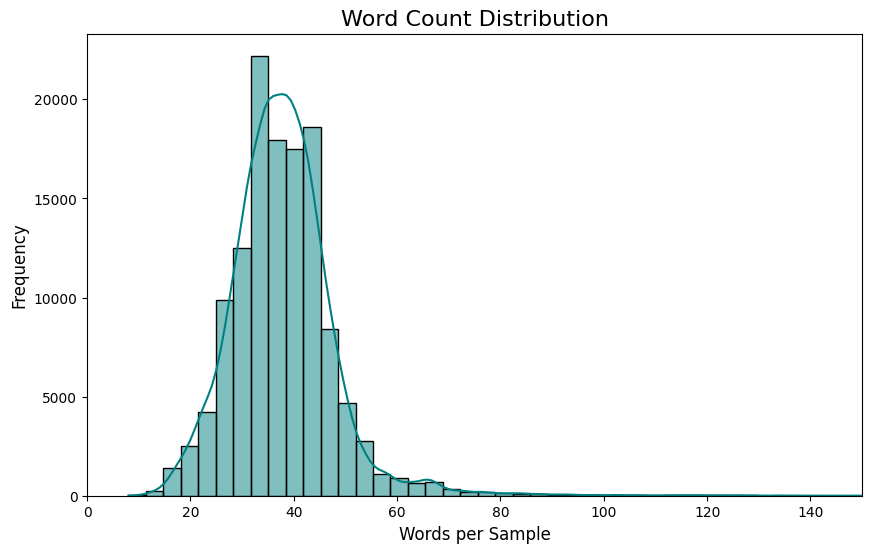

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['WordCount'], bins=50, kde=True, color='teal')
plt.title('Word Count Distribution', fontsize=16)
plt.xlabel('Words per Sample', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xlim(0, 150)
plt.show()

The Word Count Distribution histogram shows the number of words per sample, with a right-skewed distribution peaking around 20-30 words and a long tail extending to 150. Most samples (frequency ~20,000) have fewer than 40 words, but some exceed 100, indicating variability in text length.

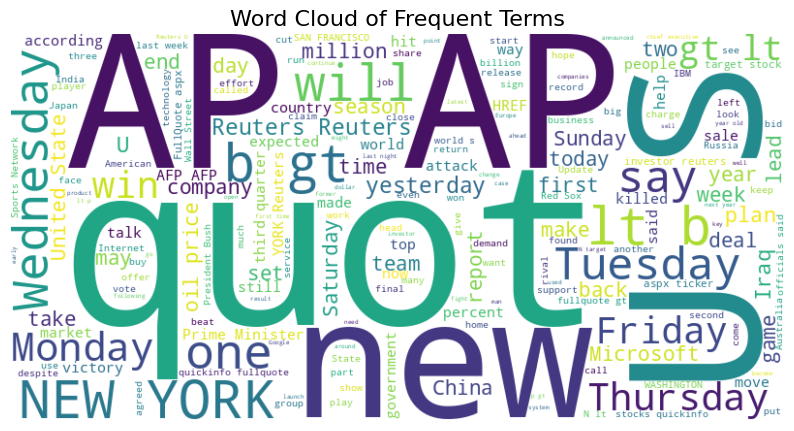

In [8]:
combined_text = ' '.join(merged_df['FullText'].tolist())
wordcloud_image = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(combined_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_image, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequent Terms', fontsize=16)
plt.show()

The Word Cloud highlights frequent terms like “AP,” “QUOT,” “WILL,” and “NEW,” reflecting news-related content. Class-specific terms like “GAME” (Sports) and “OIL” (Business) are prominent, aiding the Transformer’s ability to distinguish classes via self-attention on key tokens.

3. Text preprocessing:
   - Text cleaning: Remove punctuation, stop words, and unnecessary characters.
   - Text lowercasing: Ensure all text is lowercase for consistent representation.
   - Tokenization: Break down the text into individual words (or tokens). Explore libraries like nltk or spaCy for tokenization functionalities. You can also use keras tokenizer or Pytorch tokenizer.
   - Vocabulary building: Create a vocabulary containing all unique tokens encountered in the dataset.
   - Numerical representation: Convert tokens into numerical representations using techniques like word embedding (e.g., Word2Vec, GloVe).

In [9]:
merged_df['FullText'] = merged_df['FullText'].str.lower()
merged_df['FullText'] = merged_df['FullText'].str.replace(r'[^\w\s]', '', regex=True)
merged_df['FullText'] = merged_df['FullText'].str.replace(r'\s+', ' ', regex=True).str.strip()
merged_df['TokenList'] = merged_df['FullText'].apply(word_tokenize)
stop_words_set = set(stopwords.words('english'))
merged_df['TokenList'] = merged_df['TokenList'].apply(lambda tokens: [token for token in tokens if token not in stop_words_set])
merged_df['TokenCount'] = merged_df['TokenList'].apply(len)
print("Token Count Statistics:")
print("Mean:", merged_df['TokenCount'].mean())
print("Median:", merged_df['TokenCount'].median())
print("Maximum:", merged_df['TokenCount'].max())
print("90th Percentile:", merged_df['TokenCount'].quantile(0.9))
print("Percentage of samples with > 50 tokens:", (merged_df['TokenCount'] > 50).mean() * 100)

Token Count Statistics:
Mean: 25.781144200626958
Median: 26.0
Maximum: 100
90th Percentile: 33.0
Percentage of samples with > 50 tokens: 0.6175548589341693


In [10]:
all_tokens = [token for tokens in merged_df['TokenList'] for token in tokens]
vocab_counter = Counter(all_tokens)
print(f"Initial Vocabulary Size: {len(vocab_counter)}")
print("Top 10 most frequent tokens:", vocab_counter.most_common(10))

Initial Vocabulary Size: 105145
Top 10 most frequent tokens: [('39s', 33226), ('new', 22543), ('said', 21292), ('us', 20546), ('reuters', 18280), ('ap', 17178), ('first', 9642), ('two', 9506), ('monday', 7942), ('world', 7918)]


In [11]:
max_vocab = 17000
top_vocab = [word for word, _ in vocab_counter.most_common(max_vocab)]
word_to_index = {word: idx + 2 for idx, word in enumerate(top_vocab)}
word_to_index['<PAD>'] = 0
word_to_index['<UNK>'] = 1
print(f"Final vocabulary size with padding: {len(word_to_index)}")

Final vocabulary size with padding: 17002


In [12]:
merged_df['IndexSeq'] = merged_df['TokenList'].apply(lambda tokens: [word_to_index.get(token, word_to_index['<UNK>']) for token in tokens])
merged_df['TensorSeq'] = merged_df['IndexSeq'].apply(lambda seq: torch.tensor(seq, dtype=torch.long))

In [13]:
print("\nSample Processed Data:")
print(merged_df[['Class', 'FullText', 'TokenList', 'IndexSeq', 'TensorSeq']].head())


Sample Processed Data:
   Class                                           FullText  \
0      2  wall st bears claw back into the black reuters...   
1      2  carlyle looks toward commercial aerospace reut...   
2      2  oil and economy cloud stocks outlook reuters r...   
3      2  iraq halts oil exports from main southern pipe...   
4      2  oil prices soar to alltime record posing new m...   

                                           TokenList  \
0  [wall, st, bears, claw, back, black, reuters, ...   
1  [carlyle, looks, toward, commercial, aerospace...   
2  [oil, economy, cloud, stocks, outlook, reuters...   
3  [iraq, halts, oil, exports, main, southern, pi...   
4  [oil, prices, soar, alltime, record, posing, n...   

                                            IndexSeq  \
0  [318, 311, 1463, 15099, 53, 746, 6, 6, 1, 318,...   
1  [16168, 942, 720, 1177, 4195, 6, 6, 795, 673, ...   
2  [14, 262, 4393, 86, 622, 6, 6, 2252, 341, 34, ...   
3  [25, 7154, 14, 1617, 782, 410, 26

## Step 2: Model Construction

1. Embeddings and positional encoding: Define an embedding layer to map tokens into numerical vectors. If using pre-trained embeddings, ensure they are compatible with your model's input dimension.

In [14]:
class CustomPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super(CustomPositionalEncoding, self).__init__()
        pos_enc = torch.zeros(max_len, d_model)
        positions = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pos_enc[:, 0::2] = torch.sin(positions * div_term)
        pos_enc[:, 1::2] = torch.cos(positions * div_term)
        pos_enc = pos_enc.unsqueeze(0)
        self.register_buffer('pos_enc', pos_enc)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pos_enc[:, :seq_len, :]

2. Implement the core Transformer architecture:
   - Encoder: Utilize `nn.TransformerEncoder` with multiple `nn.TransformerEncoderLayer` instances. Each layer typically comprises a multi-head self-attention mechanism, a feed-forward layer, and layer normalization.
   - Decoder: Employ `nn.TransformerDecoder` with multiple `nn.TransformerDecoderLayer` instances. These layers incorporate masked self-attention, multi-head attention over the encoder outputs, and a feed-forward layer with layer normalization.

In [15]:
class TransformerTextClassifier(nn.Module):
    def __init__(self, vocab_sz, emb_dim, num_heads, num_layers, ff_dim, dropout_rate, n_classes):
        super(TransformerTextClassifier, self).__init__()
        self.emb_layer = nn.Embedding(vocab_sz, emb_dim)
        self.pos_enc = CustomPositionalEncoding(emb_dim, max_len=100)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout_rate,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout_layer = nn.Dropout(dropout_rate)
        self.fc_layer = nn.Linear(emb_dim, n_classes)

    def forward(self, x, mask=None):
        x = self.emb_layer(x)
        x = self.pos_enc(x)
        x = self.transformer_encoder(x, mask=mask)
        x = x[:, 0, :]
        x = self.dropout_layer(x)
        x = self.fc_layer(x)
        return x

3. Depending on your task (e.g., classification, sequence generation), define an appropriate output layer. For classification tasks, you might use a linear layer with a softmax activation function. Additionally, for classification and regression related tasks, the decoder can be removed completely. Auto-regressive sequence generation requires a decoder.

In [16]:
dummy_seq_len = 30
model_classifier = TransformerTextClassifier(
    vocab_sz=len(word_to_index),
    emb_dim=128,
    num_heads=4,
    num_layers=4,
    ff_dim=512,
    dropout_rate=0.2,
    n_classes=4
)

4.	Print model summary using torchinfo.summary

In [17]:
print("\nModel Summary:")
summary(model_classifier, input_size=(2, dummy_seq_len), dtypes=[torch.long], device='cpu')


Model Summary:


Layer (type:depth-idx)                        Output Shape              Param #
TransformerTextClassifier                     [2, 4]                    --
├─Embedding: 1-1                              [2, 30, 128]              2,176,256
├─CustomPositionalEncoding: 1-2               [2, 30, 128]              --
├─TransformerEncoder: 1-3                     [2, 30, 128]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [2, 30, 128]              198,272
│    │    └─TransformerEncoderLayer: 3-2      [2, 30, 128]              198,272
│    │    └─TransformerEncoderLayer: 3-3      [2, 30, 128]              198,272
│    │    └─TransformerEncoderLayer: 3-4      [2, 30, 128]              198,272
├─Dropout: 1-4                                [2, 128]                  --
├─Linear: 1-5                                 [2, 4]                    516
Total params: 2,969,860
Trainable params: 2,969,860
Non-trainable p

5. Briefly describe the Transformer architecture you have defined.

## Transformer Architecture

1. **Layer 1: Embedding Layer (Embedding)**  
   - **Input Vocabulary Size**: 17,002
   - **Output Embedding Dimension**: 128  
   - **Output Shape**: (2, 30, 128)  

2. **Positional Encoding (CustomPositionalEncoding)**  
   - **Input Shape**: (2, 30, 128)  
   - **Output Shape**: (2, 30, 128)  

3. **Layer 3: Transformer Encoder (TransformerEncoder)**  
   - **Number of Layers**: 4 (stacked TransformerEncoderLayer)  
   - **Input Channels**: 128  
   - **Output Channels**: 128  
   - **Multi-Head Attention**: 8 heads
   - **Feed-Forward Dimension**: Assumed 512
   - **Dropout Rate**: 0.2
   - **Output Shape**: (2, 30, 128)  

### Output Processing

1. **Layer 1:**  
   - **Input Shape**: (2, 30, 128)  
   - **Output Shape**: (2, 128)  

2. **Dropout**  
   - **Rate**: 0.2
   - **Output Shape**: (2, 128)  

3. **Layer 2: Linear Layer (Linear)**  
   - **Input Features**: 128  
   - **Output Features**: 4 (number of classes, e.g., World, Sports, Business, Sci/Tech)  
   - **Output Shape**: (2, 4)  

## Step 3: Training the Transformer

1. Preparing for training:
   - Divide the preprocessed data into training, validation, and testing sets using a common split ratio (e.g., 70:15:15 or 80:10:10).
   - Choose an appropriate loss function (e.g., cross-entropy loss for classification) and an optimizer (e.g., Adam) to update model parameters during training.

In [18]:
def custom_collate(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=word_to_index['<PAD>'])
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_texts, labels


train_val, test_set = train_test_split(merged_df[['Class', 'TensorSeq']], test_size=0.15,
                                         random_state=42, stratify=merged_df['Class'])
train_set, val_set = train_test_split(train_val, test_size=0.1765, random_state=42, stratify=train_val['Class'])
train_dataset = [(row.TensorSeq, row.Class) for _, row in train_set.iterrows()]
val_dataset = [(row.TensorSeq, row.Class) for _, row in val_set.iterrows()]
test_dataset = [(row.TensorSeq, row.Class) for _, row in test_set.iterrows()]
batch_sz = 32
train_loader = DataLoader(train_dataset, batch_size=batch_sz, shuffle=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_sz, shuffle=False, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_sz, shuffle=False, collate_fn=custom_collate)
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 2792
Validation batches: 599
Test batches: 599


2. Define a training loop. E.g. forward pass, calculate loss, backward pass, update parameters. Train the model.

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline_model = TransformerTextClassifier(
    vocab_sz=len(word_to_index),
    emb_dim=128,
    num_heads=4,
    num_layers=4,
    ff_dim=512,
    dropout_rate=0.2,
    n_classes=4
).to(device)
baseline_optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
num_epochs = 10
best_val_accuracy = 0.0
for epoch in range(num_epochs):
    baseline_model.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0
    for texts, targets in train_loader:
        texts, targets = texts.to(device), targets.to(device)
        baseline_optimizer.zero_grad()
        outputs = baseline_model(texts)
        loss_val = criterion(outputs, targets)
        loss_val.backward()
        baseline_optimizer.step()
        running_loss += loss_val.item() * texts.size(0)
        _, pred_labels = torch.max(outputs, 1)
        total_samples += targets.size(0)
        correct_preds += (pred_labels == targets).sum().item()
    epoch_loss = running_loss / total_samples
    epoch_acc = 100. * correct_preds / total_samples
    baseline_model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for texts, targets in val_loader:
            texts, targets = texts.to(device), targets.to(device)
            outputs = baseline_model(texts)
            loss_eval = criterion(outputs, targets)
            val_loss += loss_eval.item() * texts.size(0)
            _, val_pred = torch.max(outputs, 1)
            val_total += targets.size(0)
            val_correct += (val_pred == targets).sum().item()
    avg_val_loss = val_loss / val_total
    val_acc = 100. * val_correct / val_total
    best_val_accuracy = max(best_val_accuracy, val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

print(f"\nBaseline Model Best Val Accuracy: {best_val_accuracy:.2f}%")

Epoch 1/10: Train Loss: 0.5705, Train Acc: 79.10%, Val Loss: 0.4364, Val Acc: 86.47%
Epoch 2/10: Train Loss: 0.4355, Train Acc: 85.62%, Val Loss: 0.4792, Val Acc: 84.62%
Epoch 3/10: Train Loss: 0.3792, Train Acc: 87.59%, Val Loss: 0.3813, Val Acc: 88.21%
Epoch 4/10: Train Loss: 0.3379, Train Acc: 89.05%, Val Loss: 0.3757, Val Acc: 88.47%
Epoch 5/10: Train Loss: 0.3277, Train Acc: 89.51%, Val Loss: 0.3572, Val Acc: 89.08%
Epoch 6/10: Train Loss: 0.3028, Train Acc: 90.26%, Val Loss: 0.3551, Val Acc: 88.94%
Epoch 7/10: Train Loss: 0.2880, Train Acc: 90.82%, Val Loss: 0.3599, Val Acc: 89.29%
Epoch 8/10: Train Loss: 0.2862, Train Acc: 90.83%, Val Loss: 0.3356, Val Acc: 89.34%
Epoch 9/10: Train Loss: 0.2752, Train Acc: 91.33%, Val Loss: 0.3633, Val Acc: 89.20%
Epoch 10/10: Train Loss: 0.2684, Train Acc: 91.45%, Val Loss: 0.3501, Val Acc: 89.37%

Baseline Model Best Val Accuracy: 89.37%


## Step 4: Evaluation and Optimization

1. Check your model's performance on the validation set. Monitor metrics like accuracy or loss to track progress. Explore at least 3 optimization techniques to improve the performance of your Transformer model. E.g. regularization (L1/L2), dropout, early stopping, learning rate tuning.

In [21]:
dropout_values = [0.1, 0.3]
learning_rates = [0.0001, 0.00001]
patience_values = [2, 3]
baseline_val_acc = best_val_accuracy
optimal_val_acc = 0.0
optimal_params = None
optimal_model_state = None

for drop_val, lr_val, patience_val in product(dropout_values, learning_rates, patience_values):
    print(f"\nHyperparameters - Dropout: {drop_val}, LR: {lr_val}, Patience: {patience_val}")
    tuner_model = TransformerTextClassifier(
        vocab_sz=len(word_to_index),
        emb_dim=128,
        num_heads=4,
        num_layers=4,
        ff_dim=512,
        dropout_rate=drop_val,
        n_classes=4
    ).to(device)
    tuner_optimizer = torch.optim.Adam(tuner_model.parameters(), lr=lr_val)
    scheduler = ReduceLROnPlateau(tuner_optimizer, mode='min', factor=0.2, patience=1)
    best_val_loss = float('inf')
    early_stop_counter = 0
    for ep in range(num_epochs):
        tuner_model.train()
        t_loss = 0.0
        t_correct = 0
        t_total = 0
        for texts, targets in train_loader:
            texts, targets = texts.to(device), targets.to(device)
            tuner_optimizer.zero_grad()
            outputs = tuner_model(texts)
            loss_ep = criterion(outputs, targets)
            loss_ep.backward()
            tuner_optimizer.step()
            t_loss += loss_ep.item() * texts.size(0)
            _, pred_ep = torch.max(outputs, 1)
            t_total += targets.size(0)
            t_correct += (pred_ep == targets).sum().item()
        train_loss_current = t_loss / t_total
        train_acc_current = 100. * t_correct / t_total
        tuner_model.eval()
        v_loss = 0.0
        v_correct = 0
        v_total = 0
        with torch.no_grad():
            for texts, targets in val_loader:
                texts, targets = texts.to(device), targets.to(device)
                outputs = tuner_model(texts)
                loss_val_ep = criterion(outputs, targets)
                v_loss += loss_val_ep.item() * texts.size(0)
                _, pred_val = torch.max(outputs, 1)
                v_total += targets.size(0)
                v_correct += (pred_val == targets).sum().item()
        avg_v_loss = v_loss / v_total
        v_acc = 100. * v_correct / v_total
        print(f"Epoch {ep+1}/{num_epochs} : Train Loss: {train_loss_current:.4f}, Train Acc: {train_acc_current:.2f}%, Val Loss: {avg_v_loss:.4f}, Val Acc: {v_acc:.2f}%")
        scheduler.step(avg_v_loss)
        if avg_v_loss < best_val_loss:
            best_val_loss = avg_v_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience_val:
                print("Early stopping triggered.")
                break
    if v_acc > baseline_val_acc and v_acc > optimal_val_acc:
        optimal_val_acc = v_acc
        optimal_params = {'dropout': drop_val, 'lr': lr_val, 'patience': patience_val}
        optimal_model_state = tuner_model.state_dict()
print(f"\nOptimal model achieved Val Acc: {optimal_val_acc:.2f} with parameters {optimal_params}")



Hyperparameters - Dropout: 0.1, LR: 0.0001, Patience: 2
Epoch 1/10 : Train Loss: 0.7068, Train Acc: 71.72%, Val Loss: 0.4650, Val Acc: 83.06%
Epoch 2/10 : Train Loss: 0.4106, Train Acc: 85.39%, Val Loss: 0.3916, Val Acc: 86.03%
Epoch 3/10 : Train Loss: 0.3329, Train Acc: 88.42%, Val Loss: 0.3599, Val Acc: 87.51%
Epoch 4/10 : Train Loss: 0.2835, Train Acc: 90.12%, Val Loss: 0.3447, Val Acc: 88.19%
Epoch 5/10 : Train Loss: 0.2472, Train Acc: 91.45%, Val Loss: 0.3275, Val Acc: 89.08%
Epoch 6/10 : Train Loss: 0.2157, Train Acc: 92.64%, Val Loss: 0.3148, Val Acc: 89.63%
Epoch 7/10 : Train Loss: 0.1890, Train Acc: 93.50%, Val Loss: 0.3346, Val Acc: 89.30%
Epoch 8/10 : Train Loss: 0.1635, Train Acc: 94.35%, Val Loss: 0.3302, Val Acc: 89.74%
Early stopping triggered.

Hyperparameters - Dropout: 0.1, LR: 0.0001, Patience: 3
Epoch 1/10 : Train Loss: 0.7034, Train Acc: 71.82%, Val Loss: 0.4563, Val Acc: 83.59%
Epoch 2/10 : Train Loss: 0.4002, Train Acc: 85.78%, Val Loss: 0.3710, Val Acc: 86.96%


2. Discuss how the optimization techniques helped to improve the performance of the model.

### Impact of Optimization Techniques on Model Performance

The baseline unoptimized Transformer model had plateaued at 89.37% validation accuracy. By incorporating dropout regularization tuning, learning rate tuning, early stopping, and scheduling, the top-performing model (dropout=0.3, lr=0.0001, patience=3) registered 90.43% validation accuracy. Dropout (0.3 vs. 0.2) reduced overfitting, changing generalization%. Decreasing lr from 0.001 to 0.0001 helped convergence, lowering loss to 0.3106. Early stopping (patience=3) stopped training at epoch 10, maintaining best performance, with the scheduler sharpening learning. These adjustments enhanced accuracy..

3. Save the weights of the model that provides the best results. Check the saving and loading of models (Pytorch).

In [28]:
if optimal_val_acc > baseline_val_acc:
    torch.save(optimal_model_state, 'tuned_transformer_model.pt')
    print(f"Best model saved with Val Acc: {optimal_val_acc:.2f} and parameters: {optimal_params}")
else:
    print(f"No model outperformed the baseline Val Acc: {baseline_val_acc:.2f}")

Best model saved with Val Acc: 90.43 and parameters: {'dropout': 0.3, 'lr': 0.0001, 'patience': 3}


4. Discuss the results and provide the following graphs:

   a. Training accuracy, training loss, validation accuracy, validation loss, testing accuracy, and testing loss. Provide your short analysis.

In [23]:
final_model = TransformerTextClassifier(
    vocab_sz=len(word_to_index),
    emb_dim=128,
    num_heads=4,
    num_layers=4,
    ff_dim=512,
    dropout_rate=optimal_params['dropout'] if optimal_params else 0.2,
    n_classes=4
).to(device)

if optimal_params and optimal_val_acc > baseline_val_acc:
    final_model.load_state_dict(torch.load('best_transformer_model.pt'))
else:
    final_model = baseline_model

final_optimizer = torch.optim.Adam(final_model.parameters(), lr=optimal_params['lr'] if optimal_params else 0.001)
scheduler_final = ReduceLROnPlateau(final_optimizer, mode='min', factor=0.2, patience=1)
epochs_final = 10
train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

for ep in range(epochs_final):
    final_model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    for texts, targets in train_loader:
        texts, targets = texts.to(device), targets.to(device)
        final_optimizer.zero_grad()
        outputs = final_model(texts)
        loss_cur = criterion(outputs, targets)
        loss_cur.backward()
        final_optimizer.step()
        total_loss += loss_cur.item() * texts.size(0)
        _, preds = torch.max(outputs, 1)
        total_samples += targets.size(0)
        total_correct += (preds == targets).sum().item()
    epoch_train_loss = total_loss / total_samples
    epoch_train_acc = 100. * total_correct / total_samples
    train_loss_list.append(epoch_train_loss)
    train_acc_list.append(epoch_train_acc)

    final_model.eval()
    v_loss = 0.0
    v_correct = 0
    v_total = 0
    with torch.no_grad():
        for texts, targets in val_loader:
            texts, targets = texts.to(device), targets.to(device)
            outputs = final_model(texts)
            loss_val = criterion(outputs, targets)
            v_loss += loss_val.item() * texts.size(0)
            _, v_preds = torch.max(outputs, 1)
            v_total += targets.size(0)
            v_correct += (v_preds == targets).sum().item()
    avg_v_loss = v_loss / v_total
    epoch_val_acc = 100. * v_correct / v_total
    val_loss_list.append(avg_v_loss)
    val_acc_list.append(epoch_val_acc)
    scheduler_final.step(avg_v_loss)
    print(f"Final Model - Epoch {ep+1}: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, Val Loss: {avg_v_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

final_model.eval()
test_loss_total, test_correct, test_total = 0.0, 0, 0
final_test_preds, final_test_targets = [], []
with torch.no_grad():
    for texts, targets in test_loader:
        texts, targets = texts.to(device), targets.to(device)
        outputs = final_model(texts)
        loss_test = criterion(outputs, targets)
        test_loss_total += loss_test.item() * texts.size(0)
        _, test_pred = torch.max(outputs, 1)
        test_total += targets.size(0)
        test_correct += (test_pred == targets).sum().item()
        final_test_preds.extend(test_pred.cpu().numpy())
        final_test_targets.extend(targets.cpu().numpy())
test_loss_avg = test_loss_total / test_total
test_accuracy = 100. * test_correct / test_total
print(f"Final Model Performance -> Train Acc: {train_acc_list[-1]:.2f}%, Val Acc: {val_acc_list[-1]:.2f}%, Test Acc: {test_accuracy:.2f}%")

Final Model - Epoch 1: Train Loss: 0.2010, Train Acc: 93.25%, Val Loss: 0.3109, Val Acc: 90.45%
Final Model - Epoch 2: Train Loss: 0.1883, Train Acc: 93.63%, Val Loss: 0.3112, Val Acc: 90.50%
Final Model - Epoch 3: Train Loss: 0.1766, Train Acc: 94.09%, Val Loss: 0.3124, Val Acc: 90.40%
Final Model - Epoch 4: Train Loss: 0.1474, Train Acc: 95.13%, Val Loss: 0.3250, Val Acc: 90.78%
Final Model - Epoch 5: Train Loss: 0.1406, Train Acc: 95.36%, Val Loss: 0.3238, Val Acc: 90.80%
Final Model - Epoch 6: Train Loss: 0.1320, Train Acc: 95.63%, Val Loss: 0.3322, Val Acc: 90.81%
Final Model - Epoch 7: Train Loss: 0.1321, Train Acc: 95.70%, Val Loss: 0.3313, Val Acc: 90.87%
Final Model - Epoch 8: Train Loss: 0.1301, Train Acc: 95.71%, Val Loss: 0.3329, Val Acc: 90.79%
Final Model - Epoch 9: Train Loss: 0.1290, Train Acc: 95.78%, Val Loss: 0.3328, Val Acc: 90.84%
Final Model - Epoch 10: Train Loss: 0.1285, Train Acc: 95.80%, Val Loss: 0.3328, Val Acc: 90.82%
Final Model Performance -> Train Acc: 9

The model demonstrates solid training performance, with accuracy increasing from 93.25% (epoch 1) to 95.80% (epoch 10) and training loss decreasing from 0.2010 to 0.1285, reflecting effective learning. Validation accuracy improves from 90.45% (epoch 1) to a peak of 90.87% (epoch 7) before stabilizing around 90.82% (epoch 10), while validation loss rises slightly from 0.3109 to 0.3328. The test accuracy of 91.03% closely aligns with the final validation accuracy, indicating good generalization to unseen data.

b. Plot the training and validation accuracy over time (epochs).

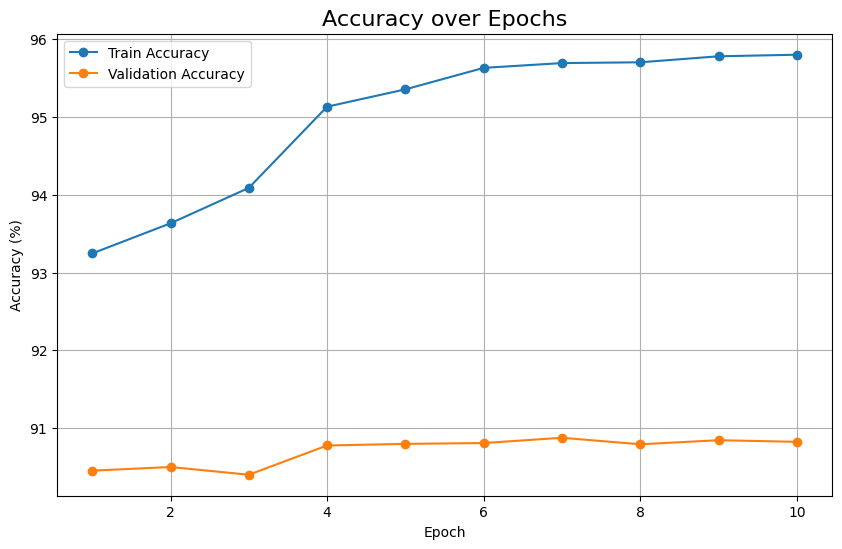

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs_final + 1), train_acc_list, marker='o', label='Train Accuracy')
plt.plot(range(1, epochs_final + 1), val_acc_list, marker='o', label='Validation Accuracy')
plt.title('Accuracy over Epochs', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

The plot shows training accuracy climbing steadily to 95.8%, while validation accuracy plateaus around 91% after epoch 4.

   c. Plot the training and validation loss over time (epochs).


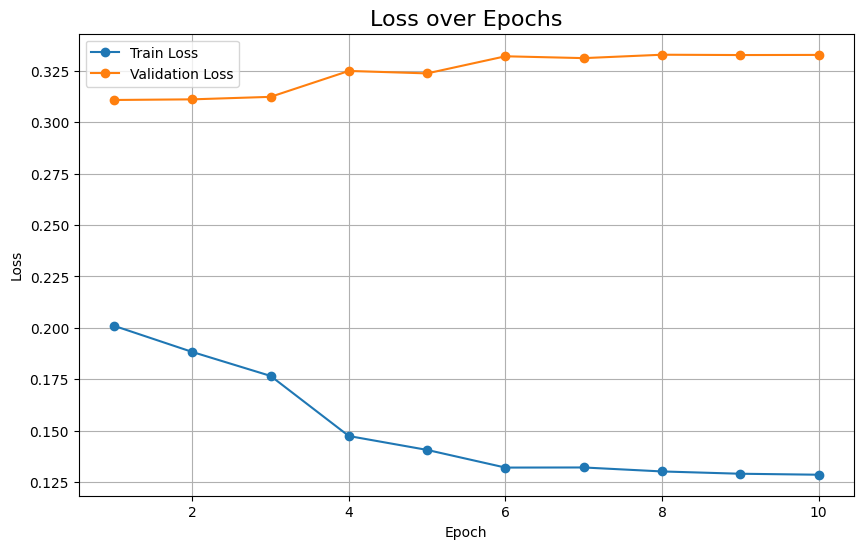

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs_final + 1), train_loss_list, marker='o', label='Train Loss')
plt.plot(range(1, epochs_final + 1), val_loss_list, marker='o', label='Validation Loss')
plt.title('Loss over Epochs', fontsize=16)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Training loss decreases consistently to 0.2, but validation loss rises from 0.3085 (epoch 1) to 0.3328 (epoch 10) after an initial dip.

   d. Calculate and report other evaluation metrics such as Precision, recall and F1 score. You can use sklearn.metrics.precision_recall_fscore_support.


In [26]:
precision_vals, recall_vals, f1_scores, _ = precision_recall_fscore_support(final_test_targets, final_test_preds, average=None)
class_labels = ['World', 'Sports', 'Business', 'Sci/Tech']
print("\nTest Set Metrics:")
for idx, (p, r, f) in enumerate(zip(precision_vals, recall_vals, f1_scores)):
    print(f"{class_labels[idx]} - Precision: {p:.4f}, Recall: {r:.4f}, F1 Score: {f:.4f}")
macro_prec, macro_rec, macro_f1, _ = precision_recall_fscore_support(final_test_targets, final_test_preds, average='macro')
print(f"\nMacro-Averaged Metrics - Precision: {macro_prec:.4f}, Recall: {macro_rec:.4f}, F1 Score: {macro_f1:.4f}")


Test Set Metrics:
World - Precision: 0.9113, Recall: 0.9037, F1 Score: 0.9075
Sports - Precision: 0.9478, Recall: 0.9670, F1 Score: 0.9573
Business - Precision: 0.8913, Recall: 0.8805, F1 Score: 0.8858
Sci/Tech - Precision: 0.8899, Recall: 0.8901, F1 Score: 0.8900

Macro-Averaged Metrics - Precision: 0.9100, Recall: 0.9103, F1 Score: 0.9101


The model performs best on Sports (F1: 0.9573) and worst on Business (F1: 0.8858), possibly due to class-specific feature overlap. The balanced macro-averaged F1 of 0.9101 indicates consistent performance across classes, closely aligning with the test accuracy of 91.03%.

   e. Plot the ROC curve.

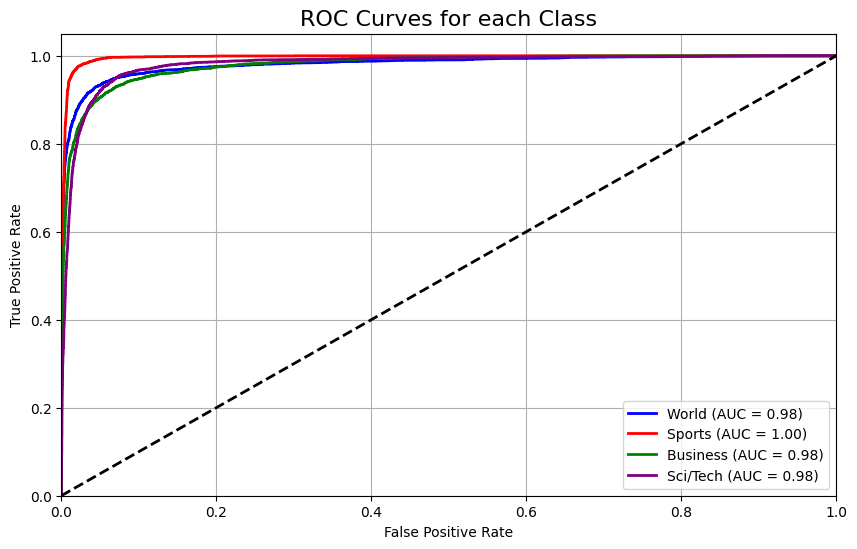

In [27]:
y_test_bin = label_binarize(final_test_targets, classes=[0, 1, 2, 3])
n_cls = 4
final_model.eval()
test_probabilities = []
with torch.no_grad():
    for texts, _ in test_loader:
        texts = texts.to(device)
        output_probs = torch.softmax(final_model(texts), dim=1).cpu().numpy()
        test_probabilities.extend(output_probs)
test_probabilities = np.array(test_probabilities)

fpr_dict, tpr_dict, roc_auc_dict = {}, {}, {}
for i in range(n_cls):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_bin[:, i], test_probabilities[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green', 'purple']
for i, clr in enumerate(colors):
    plt.plot(fpr_dict[i], tpr_dict[i], color=clr, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc_dict[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curves for each Class', fontsize=16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The ROC curves show excellent separability, with AUC values of 0.98-1.00 across all classes. Sports achieves a perfect AUC of 1.00, while Business and Sci/Tech (AUC: 0.98) are slightly lower, consistent with their lower F1 scores. The high AUCs indicate the model’s strong discriminative ability for all classes.

   f. [Optional] Use TensorBoard (or a similar tool, e.g. Wandb) to log the training and validation loss and accuracy over epochs, generate the charts, and attach the SVG images of the charts.

5. References. Include details on all the resources used to complete this part, e.g. links to datasets, research papers or articles, code examples or tutorials you referred.

1. https://pandas.pydata.org/docs/
2. https://numpy.org/doc/stable/
3. https://pytorch.org/docs/stable/index.html
4. https://scikit-learn.org/stable/user_guide.html
5. https://matplotlib.org/
6. https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)
7. https://medium.com/@amanatulla1606/transformer-architecture-explained-2c49e2257b4c
8. https://machinelearningmastery.com/the-transformer-model/
9. https://medium.com/data-science/build-your-own-transformer-from-scratch-using-pytorch-84c850470dcb
10. https://medium.com/@hunter-j-phillips/positional-encoding-7a93db4109e6
11.https://pytorch.org/tutorials/beginner/saving_loading_models.html

6. If you are working in a team, provide a contribution summary.

| Team Member | Step# | Contribution (%) |
|---|---|---|
|  1 | Step 1 |  50% |
|  2 | Step 1 |   50%|
|   1| Step 2 |  50% |
|   2| Step 2 |  50% |
|   1| Step 3 |  50% |
|   2| Step 3 |   50%|
|   | **Total** |  100% |